In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io as io 
import numpy as np

import warnings
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.simplefilter(action='ignore', category=FutureWarning)
import zipfile

import os
import glob

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Function for cropping and normalizing the images fed into the VGG16 model
No cropping is done because the images have already been pre-process using the YOLOv5 model

In [2]:
def preprocess(img):
    width, height = img.shape[0], img.shape[1]
    img = image.array_to_img(img, scale=False)

    # Crop 48x48px
    desired_width, desired_height = 224, 224

    if width < desired_width:
        desired_width = width
    start_x = np.maximum(0, int((width-desired_width)/2))

    img = img.crop((start_x, np.maximum(0, height-desired_height), start_x+desired_width, height))
    img = img.resize((224, 224))

    img = image.img_to_array(img)
    return img / 255.


Funtion to display some of the images passed into the VGG16 model

In [3]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10,5))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

Loading the pre-trained VGG16 model. An additional layer was added to the model and trained using our classes. The Dense layer with 6 units ensures that we have an output of 6 class predictions

In [4]:
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=(224,224,3),weights='imagenet')
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False
model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc', multi_label = True)])

553476096/553467096 [==============================] - 5s 0us/step


Loading Data

In [5]:
base_path = '/content/drive/MyDrive/images/results/train_images'
training_path = os.path.join(base_path, 'Train')
validation_path = os.path.join(base_path, 'CrossValidation')
testing_path = os.path.join(base_path, 'Test')

In [6]:
class_folders = glob.glob("/content/drive/MyDrive/images/results/train_images/Train/*")
print("The number of classes is: " , len(class_folders))
print(class_folders)

The number of classes is:  6
['/content/drive/MyDrive/images/results/train_images/Train/bottlenose_dolphin', '/content/drive/MyDrive/images/results/train_images/Train/blue_whale', '/content/drive/MyDrive/images/results/train_images/Train/dusky_dolphin', '/content/drive/MyDrive/images/results/train_images/Train/humpback_whale', '/content/drive/MyDrive/images/results/train_images/Train/beluga', '/content/drive/MyDrive/images/results/train_images/Train/false_killer_whale']


In [7]:
# Finding the size of the images by checking in one class
class_folders_LR = glob.glob(class_folders[0]+'/*')
image_sizes = []
for i in range(0, len(class_folders_LR)):
  im = io.imread(class_folders_LR[i])
  image_sizes.append(im.shape)

Preparing Data using ImageDataGenerator() for the VGG16 model

In [8]:
genTrain = ImageDataGenerator(preprocessing_function=preprocess)
training_data = genTrain.flow_from_directory(directory=training_path, target_size=(224,224), classes=['beluga', 'blue_whale', 'bottlenose_dolphin', 'dusky_dolphin', 'false_killer_whale', 'humpback_whale'], batch_size=10)

genValidation = ImageDataGenerator(preprocessing_function=preprocess)
validation_data = genValidation.flow_from_directory(directory=validation_path, target_size=(224,224), classes=['beluga', 'blue_whale', 'bottlenose_dolphin', 'dusky_dolphin', 'false_killer_whale', 'humpback_whale'], batch_size=10)

genTesting = ImageDataGenerator(preprocessing_function=preprocess)
testing_data = genTesting.flow_from_directory(directory=testing_path, target_size=(224,224), classes=['beluga', 'blue_whale', 'bottlenose_dolphin', 'dusky_dolphin', 'false_killer_whale', 'humpback_whale'], batch_size=10, shuffle=False)

Found 2372 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [9]:
imgs, labels = next(training_data)

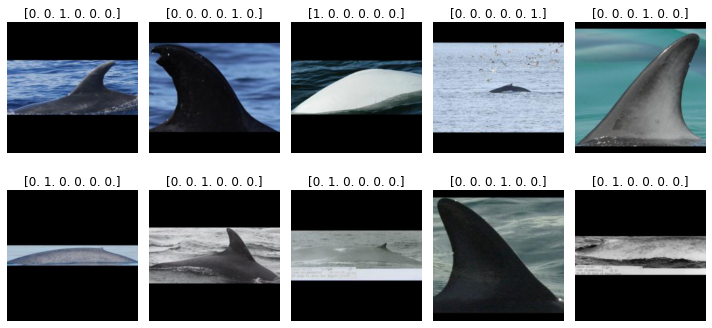

In [10]:
plotImages(imgs, labels)

Fitting VGG16 model

In [11]:
model.fit(x = training_data, validation_batch_size = validation_data, epochs=10, verbose=2)
output_layer = model.predict(x=testing_data, verbose=0)

Epoch 1/10
238/238 - 515s - loss: 1.5709 - accuracy: 0.3904 - auc: 0.7416 - 515s/epoch - 2s/step
Epoch 2/10
238/238 - 34s - loss: 1.3111 - accuracy: 0.5379 - auc: 0.8439 - 34s/epoch - 143ms/step
Epoch 3/10
238/238 - 34s - loss: 1.1804 - accuracy: 0.5965 - auc: 0.8739 - 34s/epoch - 143ms/step
Epoch 4/10
238/238 - 34s - loss: 1.1050 - accuracy: 0.6058 - auc: 0.8835 - 34s/epoch - 143ms/step
Epoch 5/10
238/238 - 34s - loss: 1.0472 - accuracy: 0.6341 - auc: 0.8935 - 34s/epoch - 142ms/step
Epoch 6/10
238/238 - 34s - loss: 1.0094 - accuracy: 0.6391 - auc: 0.8985 - 34s/epoch - 142ms/step
Epoch 7/10
238/238 - 34s - loss: 0.9797 - accuracy: 0.6488 - auc: 0.9022 - 34s/epoch - 142ms/step
Epoch 8/10
238/238 - 34s - loss: 0.9558 - accuracy: 0.6678 - auc: 0.9056 - 34s/epoch - 142ms/step
Epoch 9/10
238/238 - 34s - loss: 0.9305 - accuracy: 0.6745 - auc: 0.9102 - 34s/epoch - 142ms/step
Epoch 10/10
238/238 - 34s - loss: 0.9110 - accuracy: 0.6821 - auc: 0.9132 - 34s/epoch - 142ms/step


# **Performance Metrice**

In [12]:
Loss, Accuracy, AUC = model.evaluate(x=testing_data, verbose=2)
print("Loss: ", Loss)
print("Prediction Accuracy: ", Accuracy*100, '%')
print("AUC: ", AUC)

30/30 - 5s - loss: 0.9615 - accuracy: 0.6433 - auc: 0.9040 - 5s/epoch - 170ms/step
Loss:  0.9615130424499512
Prediction Accuracy:  64.33333158493042 %
AUC:  0.904033362865448


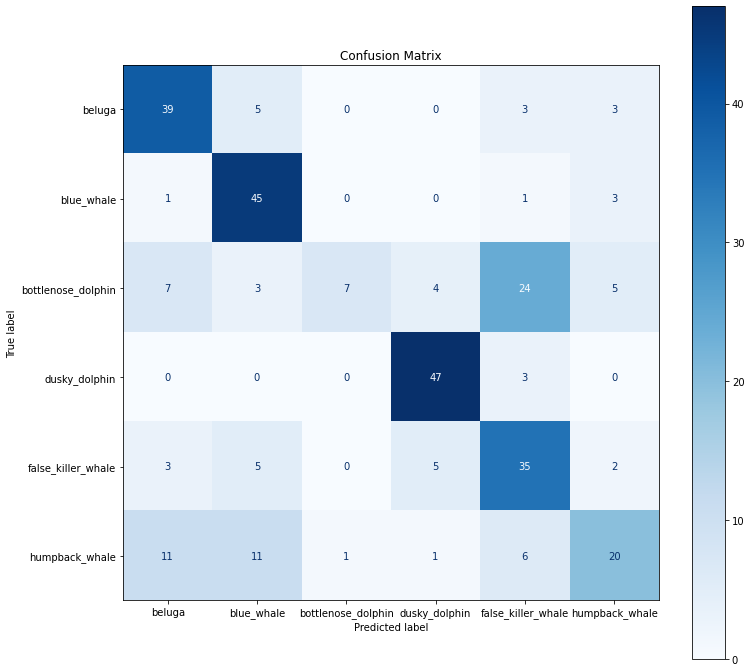

In [15]:
trueY = testing_data.classes
predictedY = np.argmax(output_layer, axis=-1)

cm = confusion_matrix(trueY, predictedY)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['beluga', 'blue_whale', 'bottlenose_dolphin', 'dusky_dolphin', 'false_killer_whale', 'humpback_whale'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

[0, 1, 2, 3, 7, 11, 12, 13, 15, 17, 18, 21, 24, 25, 27, 28, 29, 30, 33, 34, 35, 39, 44, 49]


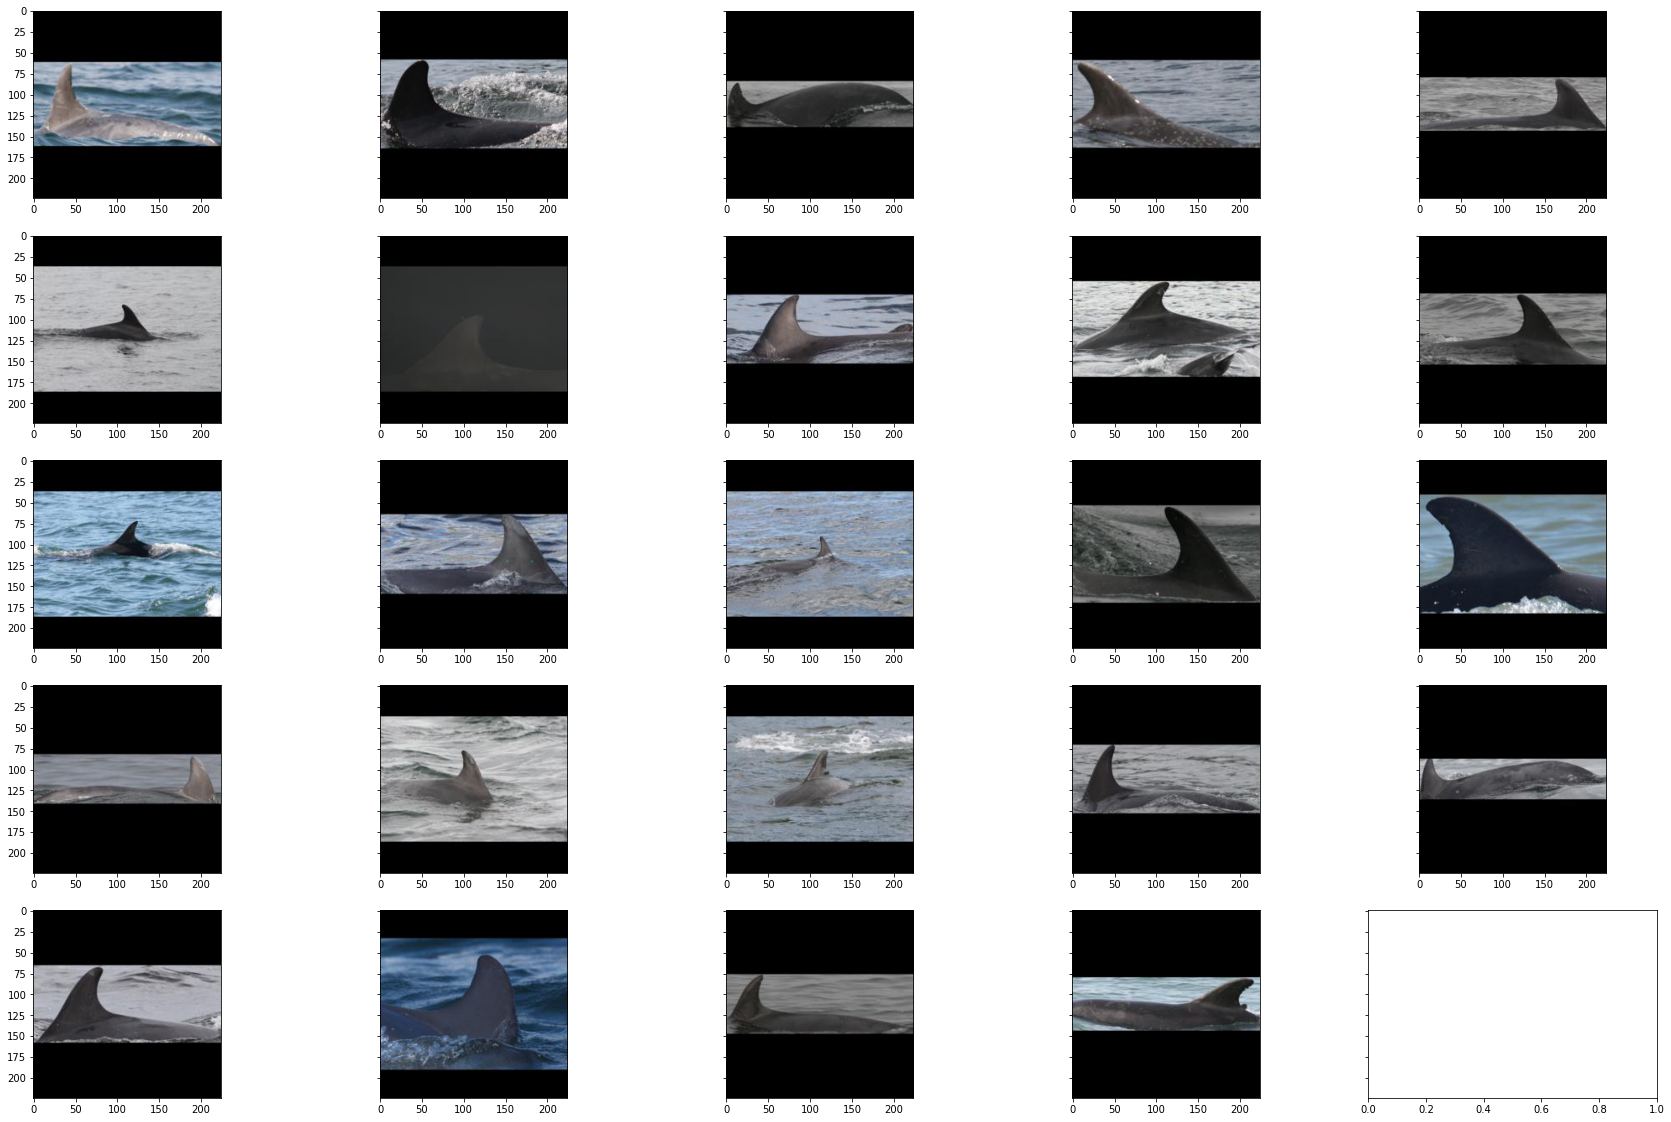

In [18]:
##PLOT WRONG CLASSIFICATIONS

index = []
for i in range(0, len(trueY)):
    if trueY[i] == 2:
        if predictedY[i]==4:
            index.append(i-100)

print(index)
training_bottle = glob.glob("/content/drive/MyDrive/images/results/train_images/Test/bottlenose_dolphin/*")

listbot = []

for ii in range(0, len(training_bottle)):
    if ii in index:
        listbot.append(training_bottle[ii])
        
f, axes = plt.subplots(round(len(listbot)/5), 5, figsize=(30, 20), sharey=True)
y = 0
for Feat in listbot:
    i, j = divmod(y, 5)
    image = io.imread(Feat)
    axes[i, j].imshow(image)
    # sb.boxplot(x=All[Feat], y = All['Class'], ax=, showfliers = False)
    y= y+1

In [19]:
report = classification_report(list(predictedY), trueY, labels=[0, 1, 2, 3, 4, 5])
print(report)

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        61
           1       0.90      0.65      0.76        69
           2       0.14      0.88      0.24         8
           3       0.94      0.82      0.88        57
           4       0.70      0.49      0.57        72
           5       0.40      0.61      0.48        33

    accuracy                           0.64       300
   macro avg       0.64      0.68      0.61       300
weighted avg       0.76      0.64      0.68       300

